In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import daft
import seaborn 
import matplotlib.pyplot as plt


C:\Users\DESUSAI\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


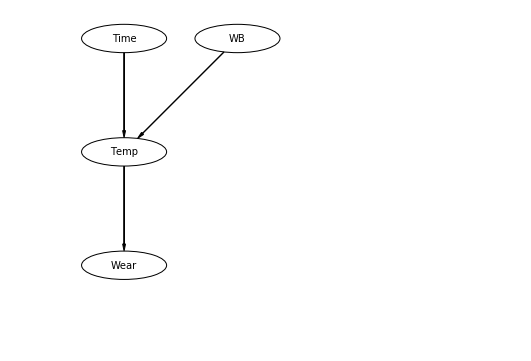

In [2]:
pgm = daft.PGM([9,6],origin=[1, 0.5])
pgm.add_node(daft.Node('Tme','Time',3,6,aspect=3))
pgm.add_node(daft.Node('WB','WB',5,6,aspect=3))
pgm.add_node(daft.Node('Temp','Temp',3,4,aspect=3))
pgm.add_node(daft.Node('Wear','Wear',3,2,aspect=3))
pgm.add_edge('Tme','Temp')
pgm.add_edge('WB','Temp')
pgm.add_edge('Temp','Wear')
pgm.render();


In [3]:
df = pd.read_csv('C:/Users/DESUSAI/Desktop/New folder/Temp.csv',sep=';')

df.index
Maxlife = 1000
intialTime=20

In [4]:
df.describe()

,Time,Temp,RunningTemp,Wear,Slot
count,5.0,5.000000,5.000000,5.000000,5.000000
mean,1.0,140.000000,172.800000,15.200000,3.000000
std,0.0,54.772256,15.205262,3.114482,1.581139
min,1.0,100.000000,166.000000,12.000000,1.000000
25%,1.0,100.000000,166.000000,13.000000,2.000000
50%,1.0,100.000000,166.000000,15.000000,3.000000
75%,1.0,200.000000,166.000000,16.000000,4.000000
max,1.0,200.000000,200.000000,20.000000,5.000000


In [5]:
temp_mean= df.Temp.mean()
temp_mean

140.0

In [6]:
df.skew()

Time           0.000000
Temp           0.608581
RunningTemp    2.236068
Wear           0.933451
Slot           0.000000
dtype: float64

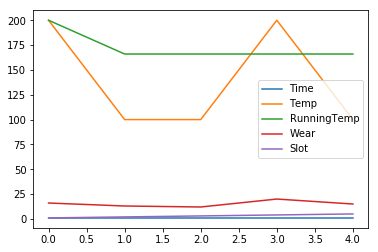

In [7]:
df.plot()
plt.show()

In [8]:
df.std

<bound method DataFrame.std of    Time  Temp  RunningTemp  Wear  Slot
0     1   200          200    16     1
1     1   100          166    13     2
2     1   100          166    12     3
3     1   200          166    20     4
4     1   100          166    15     5>

In [9]:
model = pm.Model();
with model:
    time = pm.Normal('time',intialTime)
    temp = pm.Normal('temp',mu=time)
    wear =pm.Normal('wear',mu=temp)
    trace = pm.sample(100000,tune=50000,progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\DESUSAI\AppData\Local\Continuum\anaconda3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|█████████████████████████████████| 150000/150000 [03:18<00:00, 755.72it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000FAB16D8>,
      dtype=object)

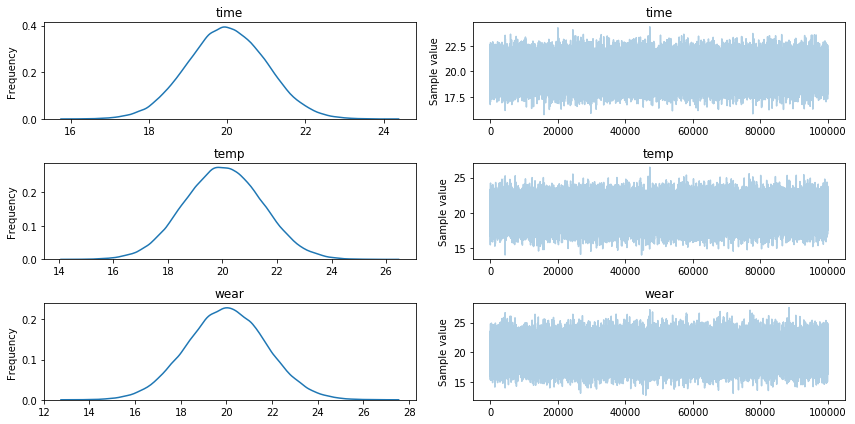

In [10]:
pm.traceplot(trace)

In [11]:
pm.summary(trace)


time:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  20.001           1.004            0.005            [18.046, 21.963]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  18.048         19.325         19.995         20.681         21.967


temp:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  20.006           1.420            0.007            [17.286, 22.824]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  17.243         19.035         20.001         20.970         22.787


wear:

  Mean             SD               MC Error         95% HPD interval
  ----------------------

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000010B71860>,
      dtype=object)

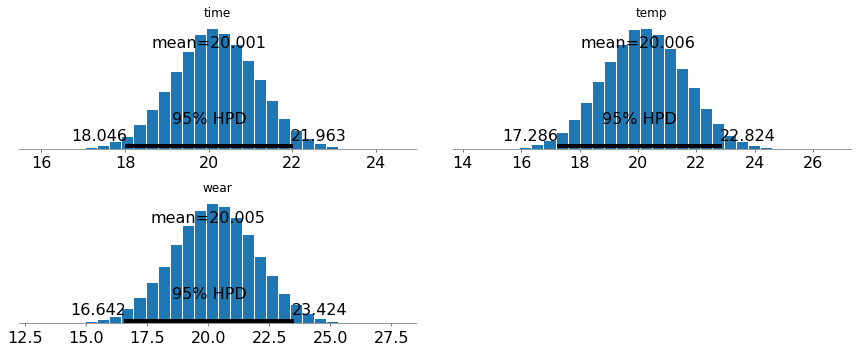

In [12]:
pm.plot_posterior(trace)

In [13]:
pred = pd.DataFrame({
    "Wear": trace["wear"][50000:],
    "Temp": trace["temp"][50000:],
    "Time": trace["time"][50000],
 
})


In [14]:
pred.Wear.mean()


20.007871004889164

In [15]:
pred.Temp.mean()
loopTime = pred.Time.mean()
loopWear = pred.Wear.mean()
loopTemp = pred.Temp.mean()

In [16]:
loopWear

20.007871004889164

In [17]:
loopTemp

20.011021136089823

In [18]:
loopTime

20.57742758386268

In [21]:
for i in range(0,len(df.Time)-1):    
    model2 = pm.Model();    
    with model2:        
        Time2 = pm.Normal('Time2',df.Time[i])
        Temp2 = pm.Normal('Temp2',mu=Time2+loopWear)
        wear2 = pm.Normal('wear2',mu=Temp2+loopWear)
        changedWear= pm.Normal('changedWear',mu=wear2-loopWear)
        trace2 = pm.sample(10000,tune=5000,progressbar=True)
    
        globals()["predStep" + str(i)]= pd.DataFrame({
                    "Wear": trace2["wear2"][5000:],
                    "temp": trace2["Temp2"][5000:],
                    "time": trace2["Time2"][5000:],
                    "WearChanged": trace2["changedWear"][5000:]            
        })
        
        globals()["predStep" + str(i)].to_csv('C:/Users/DESUSAI/Desktop/New folder/predStep_' + str(i+1)+'.csv', sep=';')
        sd=globals()["predStep" + str(i)]
        
        loopTime = globals()["predStep" + str(i)].time.mean()
        loopWear = globals()["predStep" + str(i)].Wear.mean()        
        print(df.Time[i],' sec',round(((Maxlife-loopWear)/Maxlife)*100),'% life is left')        
        seaborn.distplot(globals()["predStep" + str(i)].Wear)
        pm.traceplot(trace2)        
        pm.plot_posterior(trace2)
    
    
    

SyntaxError: can't assign to operator (<ipython-input-21-792504be22e2>, line 23)